### 3_动量轮动策略
策略描述
该策略的基本思想是始终持有过去一段时间涨幅大（动量强）的资产，在4种资产间进行轮动。构建步骤如下：

每日计算每个ETF过去21个交易日（含计算当日）的涨跌幅作为动量。

比较动量，选择动量更大的ETF作为投资标的，以当日收盘价买入对应的ETF基金。

持有所购买的ETF基金，直到下一个调仓日。

每个调仓日重复以上步骤，根据涨幅更大的指数进行轮动投资。



In [2]:
!pip install akshare
!pip install quantstats

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.5/45.5 kB 1.0 MB/s eta 0:00:00


In [3]:
import warnings
import time
import akshare as ak
import numpy as np
import pandas as pd
import quantstats as qs
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [21]:
def calculate_etf_performance(etf_symbols, windows, html_file=None):
  # 获取 ETF 历史数据
    etf_data = {}
    for symbol in etf_symbols:
        etf_df = ak.fund_etf_hist_em(symbol=symbol, period="daily", adjust="hfq")[["日期","收盘"]].rename(columns={"日期":"date","收盘":f"{symbol}"}).set_index("date")
        etf_data[symbol] = etf_df
    print(etf_data)
    # 合并数据
    data = pd.concat(list(etf_data.values()), axis=1).dropna().iloc[:]
    data.index = pd.to_datetime(data.index)

    # 计算每日涨跌幅和滚动收益率
    for symbol in etf_symbols:
        column_name = f"{symbol}"
        data[f"{column_name}_day_return"] = data[column_name].rolling(2).apply(lambda x:(x[-1]-x[0])/x[0])
        data[f"{column_name}_return"] = data[column_name].rolling(window=window).apply(lambda x: x[-1]/x[0])
        data[f"{column_name}_ma"] = data[column_name].rolling(window=window).mean()
    # 去掉缺失值
    data = data.dropna()
    data["signal"] = data[[f"{symbol}_return" for symbol in etf_symbols]].idxmax(axis=1).str.split("_").str[0]
    data["signal"] = data["signal"].shift(1)
    data = data.dropna()
    data["signal_return"] = (np.cumprod(data.apply(lambda row: row[f'{row["signal"]}_day_return'], axis=1) + 1) * 100)

    for symbol in etf_symbols:
        column_name = f"{symbol}_return"
        data[column_name] = (100/data[f"{symbol}"].values[0]) * data[f"{symbol}"]

    # 绘制曲线图
    fig, ax = plt.subplots(figsize=(15, 6))
    ax.set_xlabel('Time')
    ax.set_ylabel('Return')

    for symbol in etf_symbols:
        column_name = f"{symbol}_return"
        ax.plot(data[column_name].index, data[column_name].values)

    ax.plot(data["signal_return"].index, data["signal_return"].values)
    ax.legend(etf_symbols + ["signal_return"])

    ax.xaxis.set_major_locator(ticker.MultipleLocator(500))

    # 计算策略表现指标
    result = {}
    for symbol in etf_symbols + ["signal",]:
        column_name = f"{symbol}_return"
        result[column_name] = []
        for stat in ["avg_return", "volatility", "sharpe", "max_drawdown", "win_rate"]:
            r = getattr(qs.stats, stat)(data[column_name])
            result[column_name].append(r)

    result = pd.DataFrame(result, index=["avg_return", "volatility", "sharpe", "max_drawdown", "win_rate"])

    return result

{'518880':             518880
date              
2013-07-29   2.626
2013-07-30   2.646
2013-07-31   2.657
2013-08-01   2.643
2013-08-02   2.578
...            ...
2023-10-13   4.405
2023-10-16   4.460
2023-10-17   4.480
2023-10-18   4.523
2023-10-19   4.544

[2488 rows x 1 columns], '513100':             513100
date              
2013-05-15   0.997
2013-05-16   0.999
2013-05-17   0.997
2013-05-20   0.997
2013-05-21   0.997
...            ...
2023-10-13   5.610
2023-10-16   5.555
2023-10-17   5.595
2023-10-18   5.570
2023-10-19   5.505

[2537 rows x 1 columns], '159915':             159915
date              
2011-12-09   0.797
2011-12-12   0.790
2011-12-13   0.768
2011-12-14   0.760
2011-12-15   0.752
...            ...
2023-10-13   1.945
2023-10-16   1.906
2023-10-17   1.912
2023-10-18   1.887
2023-10-19   1.879

[2879 rows x 1 columns], '510300':             510300
date              
2012-05-28   2.604
2012-05-29   2.644
2012-05-30   2.636
2012-05-31   2.630
2012-06-01   2.630
...    

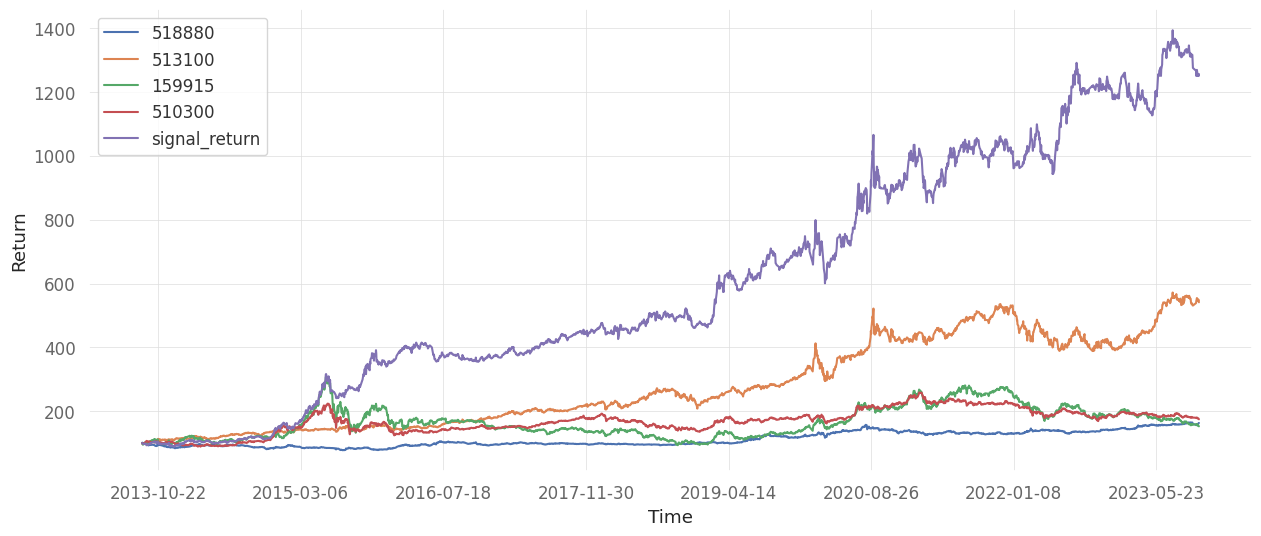

In [22]:
etf_symbols = ["518880", "513100", "159915", "510300"]
window = 21
result = calculate_etf_performance(etf_symbols, window, "out.html")
print(result)

In [23]:
# 获取 ETF 历史数据
etf_symbols = ["518880", "513100", "159915", "510300"]
window = 21
etf_data = {}
for symbol in etf_symbols:
    etf_df = ak.fund_etf_hist_em(symbol=symbol, period="daily", adjust="hfq")[["日期","收盘"]].rename(columns={"日期":"date","收盘":f"{symbol}"}).set_index("date")
    etf_data[symbol] = etf_df
print(etf_data)
# 合并数据
data = pd.concat(list(etf_data.values()), axis=1).dropna().iloc[:]
data.index = pd.to_datetime(data.index)



{'518880':             518880
date              
2013-07-29   2.626
2013-07-30   2.646
2013-07-31   2.657
2013-08-01   2.643
2013-08-02   2.578
...            ...
2023-10-13   4.405
2023-10-16   4.460
2023-10-17   4.480
2023-10-18   4.523
2023-10-19   4.546

[2488 rows x 1 columns], '513100':             513100
date              
2013-05-15   0.997
2013-05-16   0.999
2013-05-17   0.997
2013-05-20   0.997
2013-05-21   0.997
...            ...
2023-10-13   5.610
2023-10-16   5.555
2023-10-17   5.595
2023-10-18   5.570
2023-10-19   5.505

[2537 rows x 1 columns], '159915':             159915
date              
2011-12-09   0.797
2011-12-12   0.790
2011-12-13   0.768
2011-12-14   0.760
2011-12-15   0.752
...            ...
2023-10-13   1.945
2023-10-16   1.906
2023-10-17   1.912
2023-10-18   1.887
2023-10-19   1.878

[2879 rows x 1 columns], '510300':             510300
date              
2012-05-28   2.604
2012-05-29   2.644
2012-05-30   2.636
2012-05-31   2.630
2012-06-01   2.630
...    

In [29]:
data[[f"{symbol}_return" for symbol in etf_symbols]].idxmax(axis=1)

date
2013-11-28    159915_return
2013-11-29    159915_return
2013-12-02    510300_return
2013-12-03    510300_return
2013-12-04    510300_return
                  ...      
2023-10-13    513100_return
2023-10-16    518880_return
2023-10-17    513100_return
2023-10-18    518880_return
2023-10-19    518880_return
Length: 2405, dtype: object

In [33]:
# 计算每日涨跌幅和滚动收益率
for symbol in etf_symbols:
    column_name = f"{symbol}"
    data[f"{column_name}_day_return"] = data[column_name].rolling(2).apply(lambda x:(x[-1]-x[0])/x[0])
    data[f"{column_name}_return"] = data[column_name].rolling(window=window).apply(lambda x: x[-1]/x[0])
    data[f"{column_name}_ma"] = data[column_name].rolling(window=window).mean()
# 去掉缺失值
#   """2013-11-28    159915_return
# 2013-11-29    159915_return"""

data["signal"] = data[[f"{symbol}_return" for symbol in etf_symbols]].idxmax(axis=1).str.split("_").str[0]
data["signal"] = data["signal"].shift(1)
print(data["signal"])
data = data.dropna()
data["signal_return"] = (np.cumprod(data.apply(lambda row: row[f'{row["signal"]}_day_return'], axis=1) + 1) * 100)

print(data)

<ipython-input-33-2b7b6bb37c6e>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f"{column_name}_day_return"] = data[column_name].rolling(2).apply(lambda x:(x[-1]-x[0])/x[0])
<ipython-input-33-2b7b6bb37c6e>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f"{column_name}_return"] = data[column_name].rolling(window=window).apply(lambda x: x[-1]/x[0])
<ipython-input-33-2b7b6bb37c6e>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

date
2013-12-27      None
2013-12-30       NaN
2013-12-31       NaN
2014-01-02       NaN
2014-01-03       NaN
               ...  
2023-10-13    513100
2023-10-16    513100
2023-10-17    518880
2023-10-18    513100
2023-10-19    518880
Name: signal, Length: 2384, dtype: object
            518880  513100  159915  510300  518880_day_return  518880_return  \
date                                                                           
2014-01-28   2.463   1.160   1.441   2.296          -0.005250       1.036180   
2014-01-29   2.455   1.174   1.466   2.303          -0.003248       1.033249   
2014-01-30   2.461   1.163   1.463   2.272           0.002444       1.024136   
2014-02-07   2.480   1.160   1.498   2.286           0.007720       1.023102   
2014-02-10   2.501   1.172   1.516   2.350           0.008468       1.027105   
...            ...     ...     ...     ...                ...            ...   
2023-10-13   4.405   5.610   1.945   4.336           0.003417       0.978020   
20

<ipython-input-33-2b7b6bb37c6e>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["signal"] = data[[f"{symbol}_return" for symbol in etf_symbols]].idxmax(axis=1).str.split("_").str[0]
<ipython-input-33-2b7b6bb37c6e>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["signal"] = data["signal"].shift(1)
<ipython-input-33-2b7b6bb37c6e>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats

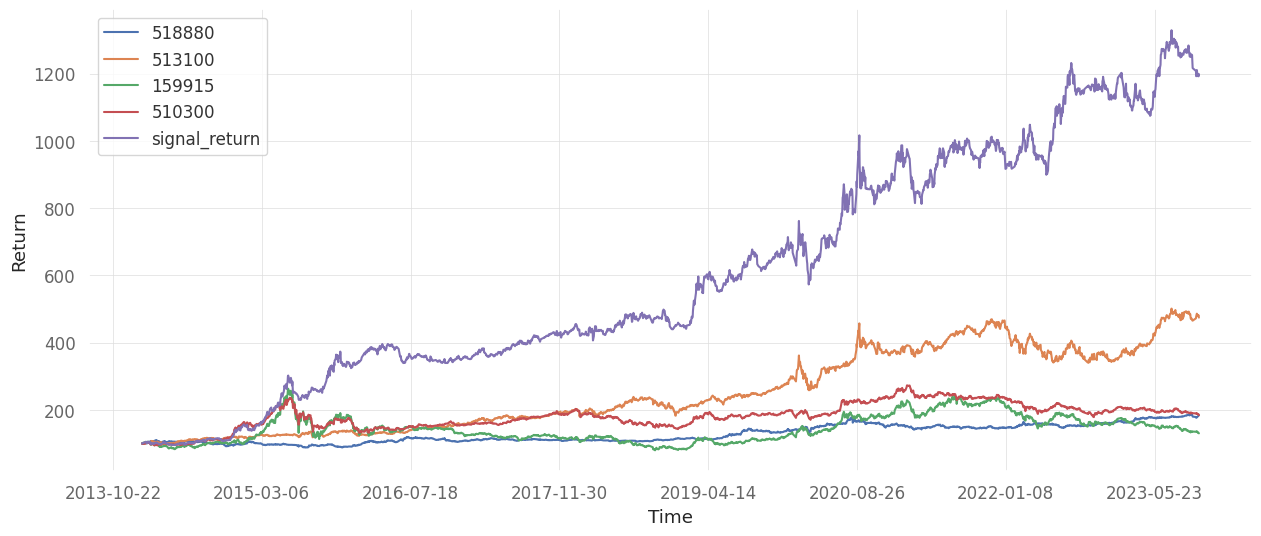

In [34]:
for symbol in etf_symbols:
        column_name = f"{symbol}_return"
        data[column_name] = (100/data[f"{symbol}"].values[0]) * data[f"{symbol}"]

# 绘制曲线图
fig, ax = plt.subplots(figsize=(15, 6))
ax.set_xlabel('Time')
ax.set_ylabel('Return')

for symbol in etf_symbols:
    column_name = f"{symbol}_return"
    ax.plot(data[column_name].index, data[column_name].values)

ax.plot(data["signal_return"].index, data["signal_return"].values)
ax.legend(etf_symbols + ["signal_return"])

ax.xaxis.set_major_locator(ticker.MultipleLocator(500))

# 计算策略表现指标
result = {}
for symbol in etf_symbols + ["signal",]:
    column_name = f"{symbol}_return"
    result[column_name] = []
    for stat in ["avg_return", "volatility", "sharpe", "max_drawdown", "win_rate"]:
        r = getattr(qs.stats, stat)(data[column_name])
        result[column_name].append(r)

result = pd.DataFrame(result, index=["avg_return", "volatility", "sharpe", "max_drawdown", "win_rate"])
